In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor

from xgboost import XGBClassifier, XGBRegressor

In [2]:
def visualize(score_list):
    train_score_list = [i['train_score'] for i in score_list]
    valid_score_list = [i['valid_score'] for i in score_list]
    plt.plot(train_score_list, label='train_score')
    plt.plot(valid_score_list, label='valid_score')
    plt.grid()
    plt.legend()

### Regression

In [3]:
df = pd.read_csv('./BlackFriday.csv')
X = df.loc[:, df.columns != 'Purchase'].copy()
y = df.loc[:, df.columns == 'Purchase'].copy()

for c in ['Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']:
    X[c] = LabelEncoder().fit_transform(X[c])

X = SimpleImputer().fit_transform(X)
y = y.values.reshape(-1)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.1)

print(X.shape, y.shape)
print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)

(537577, 11) (537577,)
(483819, 11) (483819,)
(53758, 11) (53758,)


In [4]:
class MyGradientBoostingRegressor:
    
    def __init__(self, n_estimators=100, lr=0.1, max_depth=3, verbose=False):
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth
        self.verbose = verbose
        
        self.estimator_list = None
        self.is_first = True
        self.F = None
        self.score_list = list()
        
    def fit(self, train_X, train_y):
        self.estimator_list = list()
        self.F = np.zeros_like(train_y, dtype=float)
        
        for i in range(1, self.n_estimators + 1):
            # get negative gradients
            neg_grads = train_y - self.F
            base = DecisionTreeRegressor(max_depth=self.max_depth)
            base.fit(train_X, neg_grads)
            train_preds = base.predict(train_X)
            self.estimator_list.append(base)
            
            if self.is_first:
                self.F = train_preds
                self.is_first = False
            else:
                self.F += self.lr * train_preds
                
            train_score = r2_score(train_y, self.F)
            valid_preds = self.predict(valid_X)
            valid_score = r2_score(valid_y, valid_preds)
            iter_score = dict(iter=i, train_score=train_score, valid_score=valid_score)
            self.score_list.append(iter_score)
            if self.verbose:
                print(iter_score)
                
    def predict(self, X):
        F = np.zeros_like(len(X), dtype=float)
        is_first = True
        for base in self.estimator_list:
            preds = base.predict(X)
            if is_first:
                F = preds
                is_first = False
            else:
                F += self.lr * preds
        return F

In [5]:
model = GradientBoostingRegressor(n_estimators=300, max_depth=5)
model.fit(train_X, train_y)
print('GradientBoostingRegressor train_score: {:.4f} valid_score: {:.4f}'.format(
    r2_score(train_y, model.predict(train_X)), r2_score(valid_y, model.predict(valid_X))))

model = MyGradientBoostingRegressor(n_estimators=300, max_depth=5)
model.fit(train_X, train_y)
print('MyGradientBoostingRegressor train_score: {:.4f} valid_score: {:.4f}'.format(
    r2_score(train_y, model.predict(train_X)), r2_score(valid_y, model.predict(valid_X))))

GradientBoostingRegressor train_score: 0.7106 valid_score: 0.7037
MyGradientBoostingRegressor train_score: 0.7121 valid_score: 0.7054


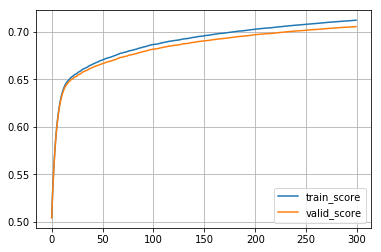

In [6]:
visualize(model.score_list)

---

### Classification

In [7]:
df = pd.read_csv('./heart.csv', index_col=0)

X = df.loc[:, df.columns != 'target'].copy()
y = df.loc[:, df.columns == 'target'].copy()

X = X.values
y = LabelEncoder().fit_transform(y)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2)
print(X.shape, y.shape)
print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)

(303, 12) (303,)
(242, 12) (242,)
(61, 12) (61,)


/Users/abbo/anaconda3/envs/dev/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
class MyGradientBoostingClassifier:
    
    def __init__(self, n_estimators=100, lr=0.1, max_depth=3, verbose=False):
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth
        self.verbose = verbose
        
        self.estimator_list = None
        self.is_first = True
        self.F = None
        self.score_list = list()
        
    def fit(self, train_X, train_y):
        self.estimator_list = list()
        self.F = np.zeros_like(train_y, dtype=float)
        
        for i in range(1, self.n_estimators + 1):
            # get negative gradients
            neg_grads = train_y - self.logit(self.F)
            base = DecisionTreeRegressor(max_depth=self.max_depth)
            base.fit(train_X, neg_grads)
            train_preds = base.predict(train_X)
            self.estimator_list.append(base)
            
            if self.is_first:
                self.F = train_preds
                self.is_first = False
            else:
                self.F += self.lr * train_preds
                
            train_preds = self.logit(self.F) > 0.5
            train_score = r2_score(train_y, train_preds)
            valid_preds = self.predict(valid_X)
            valid_score = r2_score(valid_y, valid_preds)
            iter_score = dict(iter=i, train_score=train_score, valid_score=valid_score)
            self.score_list.append(iter_score)
            if self.verbose:
                print(iter_score)
                
    def predict(self, X):
        F = np.zeros_like(len(X), dtype=float)
        is_first = True
        for base in self.estimator_list:
            preds = base.predict(X)
            if is_first:
                F = preds
                is_first = False
            else:
                F += self.lr * preds
        return self.logit(F) > 0.5
    
    @staticmethod
    def logit(F):
        return 1.0 / (1.0 + np.exp(-F))

In [9]:
model = GradientBoostingClassifier(n_estimators=100, max_depth=3)
model.fit(train_X, train_y)
print('GradientBoostingRegressor train_score: {:.4f} valid_score: {:.4f}'.format(
    r2_score(train_y, model.predict(train_X)), accuracy_score(valid_y, model.predict(valid_X))))

model = MyGradientBoostingClassifier(n_estimators=100, max_depth=3)
model.fit(train_X, train_y)
print('MyGradientBoostingRegressor train_score: {:.4f} valid_score: {:.4f}'.format(
    r2_score(train_y, model.predict(train_X)), accuracy_score(valid_y, model.predict(valid_X))))

GradientBoostingRegressor train_score: 0.9834 valid_score: 0.7705
MyGradientBoostingRegressor train_score: 0.7171 valid_score: 0.8361


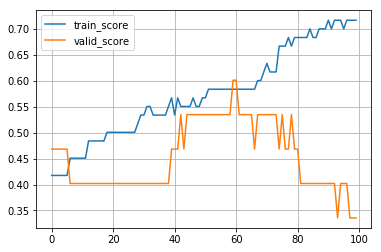

In [10]:
visualize(model.score_list)